In [22]:
"""TODO:
    - Refine narrative
    - Make plots
    - Determine presentation form.
        - Kyle very partial to some kind of web app"""

# DB- Note on file names.  I slightly edited file names (I think to include a -) so the names  would be sufficiently uniform, 
# for reading into dfs.  Let's ensure this is pushed correctly.
# RE: CSV file inputs and date ranges.  I observe there is no 2022 autonomous vehicle disengagement report- driverless on the DMV website
# Similarily, there is something going on in the driverless mileage reports.
# The 2020-21-Autonomous-Mileage-Reports-CSV-driverless covers Jan 2020 - Nov 2021
# The 2021-22-Autonomous-Mileage-Reports-CSV-driverless covers Jan 2021 - Nov 2022, but only has 3 lines, for WERIDE CORP,
#    Which doesn't appear in the 2020-21 entry.  This is probably due to a delayed filing on their part, and staff did the ez thing.
# The 2022 Report starts in Dec 2021 - Nov 2022, and doesn't include WERIDE info (either by name or permit #)
# The 2023 Report covers Dec 2022- Nov 2023, and includes WERIDE, so there is no overlaping info.

#  Re: The mileage reports.  I'm loading them in so the yeoman's work is done.  I don't want to botch joining them.
#.   Some form of groupby + set_index, as per discord, might be the trick here. 
#.   Alternatively, we can combine the permit # + VIN into a new single column, and this will enable some straightforward y/y granular tracking
#.   via joined dfs (m/m from Jan 2020 - Nov 2023)
# Finally, we should be on the lookout for permit #s that have company name changes, like the company got bought or something

'TODO:\n    - Refine narrative\n    - Make plots\n    - Determine presentation form.\n        - Kyle very partial to some kind of web app'

In [23]:
"""Narrative in broad strokes:
1. Overall trends, total miles, leaders in the space, etc.
2. Cruze story because it's interesting (backup: Waymo)
3. Follow 'zippy' the car (longest hauler)"""

"Narrative in broad strokes:\n1. Overall trends, total miles, leaders in the space, etc.\n2. Cruze story because it's interesting (backup: Waymo)\n3. Follow 'zippy' the car (longest hauler)"

In [66]:
import pandas as pd
import seaborn as sns 
import numpy
import plotly.express as px
import pprint as pprint
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


In [25]:
### Lists
## Years common across data
years = ["2020", "2021", "2022", "2023"]
years = sorted(list(years))

months = ["DEC-1", "JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JULY", "AUG", "SEP", "OCT", "NOV"]


In [26]:
# TODO: Cast DATE column as datetype for disengagements

## Read in mileage data
mile_dfs = []
for year in years:
    try:
        annual_mileage = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV.csv", encoding='utf-8')
    # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_mileage = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV.csv", encoding='latin-1')
    annual_mileage["Year"] = year
    annual_mileage.rename(columns={'ANNUAL TOTAL': 'Mileage Total'}, inplace=True)
    for i, month in enumerate(months, start=4):
        annual_mileage.columns.values[i] = month
    mile_dfs.append(annual_mileage)
    # INFO: each annual report has 22 cols

mileage_df = pd.concat(mile_dfs, ignore_index=True)
# mileage_df.set_index('VIN NUMBER', inplace=True)

File for year 2020 not found. Skipping...


In [27]:
### Read in data
## Read in disengagements data
dis_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV.csv", encoding='utf-8')
    # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV.csv", encoding='latin-1')
    dis_dfs.append(annual_disengagements)
    
disengagement_df = pd.concat(dis_dfs, ignore_index=True)

#DB.  The unnamed column 10 only appears in the 2021 report, and the 71 entries are all for IMAGRY INC.,
# Reading "Perception" or "Planning"
# Dropped Column
disengagement_df = disengagement_df.drop('Unnamed: 9', axis=1)
#Apx 8k  empty rows.  Droped all rows with any nulls.  
disengagement_df.dropna(axis=0, how='any', inplace=True)

File for year 2020 not found. Skipping...


In [28]:
# Adding in 1st time filer Disengagements.  Utilizing Kyle's code from above
first_time_dis_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-{str(int(year[3]) + 21)}-Autonomous-Vehicle-Disengagement-Reports-CSV-first-time-filers.csv", encoding='utf-8')
    except FileNotFoundError:
        print(f"File for year {year}-{str(int(year[3]) + 21)} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-{str(int(year[3]) + 21)}-Autonomous-Vehicle-Disengagement-Reports-CSV-first-time-filers.csv", encoding='latin-1')
    first_time_dis_dfs.append(annual_disengagements)
    
first_df = pd.concat(first_time_dis_dfs, ignore_index=True)
#Some 200ish null rows imported. Dropped any row with any missing data
first_df.dropna(axis=0, how='any', inplace=True)

File for year 2023-24 not found. Skipping...


In [29]:
# Driverless reports.  2022 is missing.  There are only 2 files here.  I've combined the above 2x for loops to snag them both, 
# since they have different naming conventions
driverless_dis_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-{str(int(year[3]) + 21)}-Autonomous-Vehicle-Disengagement-Reports-CSV-driverless.csv", encoding='utf-8')
    except FileNotFoundError:
        print(f"File for year {year}-{str(int(year[3]) + 21)} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-{str(int(year[3]) + 21)}-Autonomous-Vehicle-Disengagement-Reports-CSV-driverless.csv", encoding='latin-1')
    driverless_dis_dfs.append(annual_disengagements)

for year in years:    
    try:
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV-driverless.csv", encoding='utf-8')
        # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
        # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Disengagements/{year}-Autonomous-Vehicle-Disengagement-Reports-CSV-driverless.csv", encoding='latin-1')
    driverless_dis_dfs.append(annual_disengagements)

autonomous_dis_df = pd.concat(driverless_dis_dfs, ignore_index=True)
# Dropping some 2000+ null rows.
autonomous_dis_df.dropna(axis=0, how='any', inplace=True)

File for year 2021-22 not found. Skipping...
File for year 2022-23 not found. Skipping...
File for year 2023-24 not found. Skipping...
File for year 2020 not found. Skipping...
File for year 2021 not found. Skipping...
File for year 2022 not found. Skipping...


In [30]:
# 3x active DFs for the disengagement info are
# disengagement_df
# first_df
# autonomous_dis_df
# List of these objects to for loop the DATE cleanup.  
# IF we wanted to acccess the report source from the combined df, we could add a column to each, with the report source

# Initially had trouble by converting the dates to_datetime and then trying to drop the hour/min/sec.
# Resolved by first converting DATE to str, dropping everything after " " (since all times were separated from date by a space)
# And then subsequently converting the column to_datetime

# This works, but can't be re-run unless above code blocks that create the dfs are also re-run (I think).  
# Used print(i['DATE'].value_counts()) to confirm this came out correctly.  

disengagement_dfs_list = [disengagement_df, first_df, autonomous_dis_df]

for i in disengagement_dfs_list:
    i['DATE'] = i['DATE'].astype(str)
    i["DATE"] = i["DATE"].str.split(" ", expand=True)[0]
    i['DATE'] = pd.to_datetime(i['DATE'], errors='raise', dayfirst=True, format='mixed')

In [31]:
'''
for i in disengagement_dfs_list:
    #print(i['Permit Number'].value_counts())
    print(i.shape)
'''

# Operator-in-Vehicle = AVT Permit prefix
# NVO = AVDT Permit Prefix.
# I'm fairly certain splitting these into distinct columns for purposes of multi-indexed rows or columns is straightforward, 
# So am moving forward with data cleaning

"\nfor i in disengagement_dfs_list:\n    #print(i['Permit Number'].value_counts())\n    print(i.shape)\n"

In [32]:
# 3x disengagement df's combined together into one, single column for all permit info
combined_dis_df = pd.concat(disengagement_dfs_list, ignore_index=True)
# Reduce duplication
combined_dis_df['DISENGAGEMENT INITIATED BY\n(AV System, Test Driver, Remote Operator, or Passenger)'] = combined_dis_df['DISENGAGEMENT INITIATED BY\n(AV System, Test Driver, Remote Operator, or Passenger)'].str.upper()
# Categorize by codes

In [70]:
combined_dis_df.head(30)


,Manufacturer,Permit Number,DATE,VIN NUMBER,VEHICLE IS CAPABLE OF OPERATING WITHOUT A DRIVER\n(Yes or No),DRIVER PRESENT\n(Yes or No),"DISENGAGEMENT INITIATED BY\n(AV System, Test Driver, Remote Operator, or Passenger)","DISENGAGEMENT\nLOCATION\n(Interstate, Freeway, Highway, Rural Road, Street, or Parking Facility)",DESCRIPTION OF FACTS CAUSING DISENGAGEMENT
0,AIMOTIVE INC.,AVT036,2021-04-03,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,During an exit/merge the test vehicle was goin...
1,AIMOTIVE INC.,AVT036,2021-03-16,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,"Exit/Merge Lane departure, due to the car miss..."
2,AIMOTIVE INC.,AVT036,2021-03-16,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,"Exit/Merge Lane departure, due to the car miss..."
3,AIMOTIVE INC.,AVT036,2021-03-16,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,During an exit/merge the test vehicle was goin...
4,AIMOTIVE INC.,AVT036,2021-02-04,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,"The car should have stayed in the left lane, b..."
5,AIMOTIVE INC.,AVT036,2021-02-04,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,"Exit/Merge Lane departure, due to the car miss..."
6,AIMOTIVE INC.,AVT036,2021-04-13,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,During an exit/merge the test vehicle was goin...
7,AIMOTIVE INC.,AVT036,2021-04-14,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,During an exit/merge the test vehicle was goin...
8,AIMOTIVE INC.,AVT036,2021-04-16,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,During an exit/merge the test vehicle was goin...
9,AIMOTIVE INC.,AVT036,2021-04-16,JTDKN3DU9A0059509,No,Yes,TEST DRIVER,FREEWAY,"The car should have stayed in the left lane, b..."


In [64]:
# Kyle - Reduce duplicates
combined_dis_df["DISENGAGEMENT\nLOCATION\n(Interstate, Freeway, Highway, Rural Road, Street, or Parking Facility)"] = combined_dis_df["DISENGAGEMENT\nLOCATION\n(Interstate, Freeway, Highway, Rural Road, Street, or Parking Facility)"].str.upper()


15
['Freeway' 'Street' 'Highway' 'street' 'freeway' 'Parking Facility'
 'STREET' 'HIGHWAY' 'Rural Road' 'Urban' 'Interstate' 'Parking facility'
 'Express Way' 'HIghway' 'Freeway ']
9
['FREEWAY' 'STREET' 'HIGHWAY' 'PARKING FACILITY' 'RURAL ROAD' 'URBAN'
 'INTERSTATE' 'EXPRESS WAY' 'FREEWAY ']


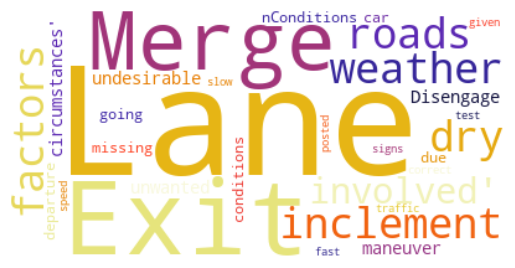

In [105]:
# Kyle - Word cloud of Disengagement descriptions
text = combined_dis_df["DESCRIPTION OF FACTS CAUSING DISENGAGEMENT"].values 

stop_words = ["vehicle", "/n", "Non", "road"] + list(STOPWORDS)
wordcloud = WordCloud(stopwords = stop_words, background_color="white", colormap="CMRmap").generate(str(text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



In [103]:
print(STOPWORDS)

{"that's", "she'd", 'from', 'in', 'of', "they're", 'does', 'each', 'about', 'like', "what's", 'when', 'hers', 'he', 'most', 'further', 'above', 'ours', "you've", 'are', 'too', 'than', 'because', 'it', "he'd", 'only', 'while', "couldn't", 'nor', 'against', 'between', 'r', "shan't", 'ought', "here's", 'both', "i'll", 'otherwise', 'yourself', 'also', 'through', 'if', 'itself', "she'll", 'has', 'those', 'to', 'been', 'then', 'she', 'why', "wasn't", 'down', 'is', 'my', 'that', 'his', 'up', 'being', 'or', 'whom', "i've", 'shall', "he'll", 'all', 'over', 'very', 'after', 'they', 'just', "who's", 'its', 'http', 'i', 'k', "you'll", 'some', 'yours', 'there', "i'd", 'theirs', "haven't", "why's", "mustn't", "hasn't", "doesn't", 'here', "hadn't", 'herself', 'have', 'myself', 'your', 'ever', 'under', 'and', "i'm", "she's", 'was', 'before', 'below', 'the', 'who', 'else', "wouldn't", "shouldn't", 'com', 'own', 'yourselves', 'get', "they'll", 'had', 'this', 'which', 'same', "how's", 'but', 'a', 'so', '

In [99]:
# DB - Using the same process I used above, for Autonomous-Mileage-Reports-CSV-driverless.csv & Autonomous-Mileage-Reports-CSV-first-time-filers.csv

In [35]:
# DB - Using the same process I used above, for Autonomous-Mileage-Reports-CSV-driverless.csv & Autonomous-Mileage-Reports-CSV-first-time-filers.csv
mile_driverless_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-{str(int(year[3]) + 21)}-Autonomous-Mileage-Reports-CSV-driverless.csv", encoding='utf-8')
    except FileNotFoundError:
        print(f"File for year {year}-{str(int(year[3]) + 21)} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-{str(int(year[3]) + 21)}-Autonomous-Mileage-Reports-CSV-driverless.csv", encoding='latin-1')
    annual_disengagements["Year"] = year
    for i, month in enumerate(months, start=4):
        annual_disengagements.columns.values[i] = month
    mile_driverless_dfs.append(annual_disengagements)

for year in years:    
    try:
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV-driverless.csv", encoding='utf-8')
        # Allows the search to be broad
    except FileNotFoundError:
        print(f"File for year {year} not found. Skipping...")
        continue
        # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-Autonomous-Mileage-Reports-CSV-driverless.csv", encoding='latin-1')
    annual_disengagements["Year"] = year
    for i, month in enumerate(months, start=4):
        annual_disengagements.columns.values[i] = month
    mile_driverless_dfs.append(annual_disengagements)

miles_test_conc = pd.concat(mile_driverless_dfs, ignore_index=True)
# Not combining due to join issue raised at top of document
#driverless_mileage_df = pd.concat(mile_driverless_dfs, ignore_index=True)

#print(mile_driverless_dfs[0].head())
print("# of objects in mile_driverless_dfs:  " + str(len(mile_driverless_dfs)))
miles_test_conc.head()


File for year 2022-23 not found. Skipping...
File for year 2023-24 not found. Skipping...
File for year 2020 not found. Skipping...
File for year 2021 not found. Skipping...
# of objects in mile_driverless_dfs:  4


,Manufacturer,Permit Number,VIN NUMBER,Annual Total of Disengagements,DEC-1,JAN,FEB,MAR,APR,MAY,...,JULY 2022,AUG 2022,SEP 2022,OCT 2022,NOV 2022,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,APOLLO AUTONOMOUS DRIVING USA LLC,AVDT006,3LN6L5LU2HR615153,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,APOLLO AUTONOMOUS DRIVING USA LLC,AVDT006,3LN6L2LU4GR629715,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,APOLLO AUTONOMOUS DRIVING USA LLC,AVDT006,2C4RC1N71LR2S2232,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CRUISE LLC,AVDT005,5G21A6P00L4100040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CRUISE LLC,AVDT005,5G21A6P01L4100029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
mile_first_time_filer_dfs = []
for year in years:
    try:
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-{str(int(year[3]) + 21)}-Autonomous-Mileage-Reports-CSV-first-time-filers.csv", encoding='utf-8')
    except FileNotFoundError:
        print(f"File for year {year}-{str(int(year[3]) + 21)} not found. Skipping...")
        continue
    # Got some kind of unicode error. This fixed it.
    except UnicodeDecodeError:
        # If utf-8 decoding fails, try another common encoding
        annual_disengagements = pd.read_csv(f"data/Mileage/{year}-{str(int(year[3]) + 21)}-Autonomous-Mileage-Reports-CSV-first-time-filers.csv", encoding='latin-1')
    mile_first_time_filer_dfs.append(annual_disengagements)
    
# Not combining due to join issue raised at top of document
#first_time_mileage_df = pd.concat(mile_first_time_filer, ignore_index=True)

#print(mile_first_time_filer_dfs[0].head())
print("# of objects in mile_driverless_dfs:  " + str(len(mile_first_time_filer_dfs)))

File for year 2023-24 not found. Skipping...
# of objects in mile_driverless_dfs:  3


In [37]:
# What are "Unnamed" colums? Probably useless "reserved"
# This and below are from kyle, and deal with the initial mileage_df
unnamed_cols = ['Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21']
for check in unnamed_cols:
    non_null_count = mileage_df[check].notna().sum()
    print(f'Number of non values in {check}: {non_null_count}')

# Empty. Drop 'em
mileage_df = mileage_df.drop(columns=unnamed_cols)
mileage_df.columns


Number of non values in Unnamed: 17: 0
Number of non values in Unnamed: 18: 0
Number of non values in Unnamed: 19: 0
Number of non values in Unnamed: 20: 0
Number of non values in Unnamed: 21: 0


Index(['Manufacturer', 'Permit Number', 'VIN NUMBER',
       'Annual Total of Disengagements', 'DEC-1', 'JAN', 'FEB', 'MAR', 'APR',
       'MAY', 'JUN', 'JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'Mileage Total',
       'Year'],
      dtype='object')

In [38]:
print(mileage_df.dtypes)

Manufacturer                       object
Permit Number                      object
VIN NUMBER                         object
Annual Total of Disengagements    float64
DEC-1                              object
JAN                                object
FEB                                object
MAR                                object
APR                                object
MAY                                object
JUN                                object
JULY                               object
AUG                                object
SEP                                object
OCT                                object
NOV                                object
Mileage Total                      object
Year                               object
dtype: object


In [39]:
### Cleaning up types
cast_as_float = [
       'Annual Total of Disengagements', 'DEC-1', 'JAN', 'FEB', 'MAR', 'APR',
       'MAY', 'JUN', 'JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'Mileage Total',
       ]

for col in cast_as_float:
    mileage_df[col] = mileage_df[col].apply(lambda x: x.replace(',', '').replace(' ', '') if isinstance(x, str) else x)
    mileage_df[col] = mileage_df[col].astype(float)

# Assuming df is your DataFrame and 'Column_Name' is the name of the column you want to convert to represent years
mileage_df['Year'] = pd.to_datetime(mileage_df['Year']).dt.year
mileage_df["Manufacturer"] = mileage_df["Manufacturer"].astype(str)


print(mileage_df.dtypes)



Manufacturer                       object
Permit Number                      object
VIN NUMBER                         object
Annual Total of Disengagements    float64
DEC-1                             float64
JAN                               float64
FEB                               float64
MAR                               float64
APR                               float64
MAY                               float64
JUN                               float64
JULY                              float64
AUG                               float64
SEP                               float64
OCT                               float64
NOV                               float64
Mileage Total                     float64
Year                                int32
dtype: object


In [40]:
### QA the monthly vs sum values
# Calculate the sum of values in the month columns for each row
month_sums = mileage_df.iloc[:, 4:-2].sum(axis=1)  

# Calculate the absolute difference between the sum of month columns and the "Mileage Total" column
absolute_difference = abs(month_sums - mileage_df['Mileage Total'])

# Check if the absolute difference is less than or equal to 2.0
within_tolerance = absolute_difference <= 2.0
fishy = (~within_tolerance).sum()
print("Number of rows where months do not add up to within 1.0 of annual total:", fishy)

# Print rows where the absolute difference is not within 2.0
# print(mileage_df[~within_tolerance])
qa = mileage_df[~within_tolerance]
print(f'Rows where MileageTotal is null: {qa["Mileage Total"].isnull().sum()}')
qa.head()


# count all nulls 
print(mileage_df.isnull().sum())
mileage_df.dropna(subset=['Mileage Total'], inplace=True)
# Drops majority of other nulls
print(mileage_df.isnull().sum())


Number of rows where months do not add up to within 1.0 of annual total: 78
Rows where MileageTotal is null: 77
Manufacturer                       0
Permit Number                     30
VIN NUMBER                        30
Annual Total of Disengagements    30
DEC-1                             30
JAN                               30
FEB                               31
MAR                               31
APR                               31
MAY                               31
JUN                               32
JULY                              32
AUG                               33
SEP                               32
OCT                               33
NOV                               32
Mileage Total                     77
Year                               0
dtype: int64
Manufacturer                      0
Permit Number                     0
VIN NUMBER                        0
Annual Total of Disengagements    0
DEC-1                             0
JAN                          

In [41]:
# QA Operators
print("Number of unique operators: ", mileage_df["Manufacturer"].nunique())
mileage_df["Manufacturer"] = mileage_df["Manufacturer"].str.replace('.', '').str.replace(',', '').str.upper()

operators = sorted(mileage_df["Manufacturer"].unique())
for value in operators:
    print(value)

# TODO: Mop up the last operators name alignment
# mileage_df["Manufacturer"] = mileage_df["Manufacturer"].str.replace('long_duplicates', 'shorter_version')
print("Actual number of unique operators: ", mileage_df["Manufacturer"].nunique())



Number of unique operators:  50
AIMOTIVE INC
APOLLO
APOLLO AUTONOMOUS DRIVING USA LLC
APPLE INC
ARGO AI LLC
AURORA OPERATIONS INC
AUTOX
AUTOX TECHNOLOGIES INC
BOSCH
CRUISE LLC
DEEPROUTEAI
DIDI RESEARCH AMERICA
DIDI RESEARCH AMERICA LLC
EASYMILE
GATIK AI INC
GHOST AUTONOMY INC
IMAGRY INC
IMAGRY INC 
INTEL CORPORATION
LYFT
MERCEDES
MERCEDES-BENZ RESEARCH & DEVELOPMENT NORTH AMERICA INC
MOTIONAL AD INC
NISSAN
NISSAN NORTH AMERICA INC DBA ALLIANCE INNOVATION LAB
NURO INC
NVIDIA
NVIDIA CORPORATION
PONYAI INC
QCRAFT INC
QUALCOMM TECHNOLOGIES INC
TOYOTA RESEARCH INSTITUTE
TOYOTA RESEARCH INSTITUTE INC
UDELV INC
VALEO NORTH AMERICA
VALEO NORTH AMERICA INC
WAYMO LLC
WERIDE CORP
WOVEN BY TOYOTA US INC
ZOOX INC
Actual number of unique operators:  40


In [42]:
nonzero_mileage = mileage_df[(mileage_df["Mileage Total"] > 0)]

In [43]:
###  autonomous miles necessarily.  Need to look at data sources further.

# TODO: Drop zeroes? Probably.

#### Histogram: miles driven / VIN ######
vin = px.histogram(nonzero_mileage,
             x='Mileage Total', color="Manufacturer", title="Autonomous Mileage by Vehicle (2021-2023)", nbins=50)
vin.update_layout(xaxis_title='Vehicle Mileage', yaxis_title='Number of Vehicles')
vin.show()

#### Histogram: miles driven / Operator ######
manufacturer_miles_sum = nonzero_mileage.groupby('Manufacturer')['Mileage Total'].sum().reset_index()

fig = px.histogram(manufacturer_miles_sum, x='Mileage Total', title='Total Miles Driven Per Operator (2021-2023)',
                   labels={'Mileage Total': 'Total Miles Driven'},  nbins=100)  # Adjust nbins as needed
fig.update_layout(yaxis_title='Operators')

fig.show()




#### WANT: Would be absolutley sick if we could start with the VINs histogram and animated into the by Operator graph...


In [44]:
### Miles driven donut by operator? only a few DOMINATE the space.
## No need? Show by above graphs?

In [45]:
### Check if any manufacturers have multiple permit numbers?

In [46]:
# sunburst of mileage by month? 
# what sotry? weather vehicles can/can't run in


In [47]:
### Scatter of number of VINs and total miles? by manufacturer
# Bubble size number of disengagements?

In [48]:
### Scatter of x=miles driven, y=disengagements, by VIN? color by manufacturer

In [49]:
#### Total Miles driven per year ####
# Aggregate the sum of "Mileage Total" by "Year" and "Manufacturer"
agg_df = mileage_df.groupby(['Manufacturer', 'Year'])['Mileage Total'].sum().reset_index()

# Filter to include only data for the top 10 operators
top_10_operators = mileage_df.groupby('Manufacturer')['Mileage Total'].sum().nlargest(10).index
top_miles = agg_df[agg_df['Manufacturer'].isin(top_10_operators)]
manufacturer_order = agg_df.groupby('Manufacturer')['Mileage Total'].sum().sort_values(ascending=False).index


# Create the bar plot
fig = px.bar(top_miles, x='Year', y='Mileage Total', color='Manufacturer', text="Manufacturer", title='Annual Autonomous Mileage Totals', category_orders={'Manufacturer': manufacturer_order})
fig.update_layout(xaxis_title='Year', yaxis_title='Mileage Total')
fig.update_xaxes(tickvals=[2021, 2022, 2023])
fig.show()


In [50]:
### Duplicate of above, but line

# Create line plot
fig = px.line(top_miles, x='Year', y='Mileage Total', color='Manufacturer', text="Manufacturer", title='Annual Mileage Total by Operator')
fig.update_layout(xaxis_title='Year', yaxis_title='Mileage Total')
fig.update_xaxes(tickvals=[2021, 2022, 2023])
fig.show()

In [51]:
#### DISENGAGEMENTS PER THOUSAND MILES DRIVEN
# Makes most sense to show by year on a per-company basis. 

# Group by manufacturer - get VIN count, total disengagments and total miles
dptm = nonzero_mileage.groupby(['Manufacturer', 'Year']).agg({'Mileage Total': 'sum',
                                                              'Annual Total of Disengagements': 'sum',
                                                              'VIN NUMBER': 'nunique'}).reset_index()
# Calculate DPTM
dptm["Disengagements/Thousand Miles"] = (dptm['Annual Total of Disengagements'] / (dptm['Mileage Total'] / 1000))

# Lowest DPTM Operators
smoothest_operators = dptm.groupby('Manufacturer')['Disengagements/Thousand Miles'].sum().nsmallest(10).index
# Simple Yearly Aggregate of DPTM per Operator
agg_2 = dptm.groupby(['Manufacturer', 'Year'])['Disengagements/Thousand Miles'].sum().reset_index()
# agg_2 filtered by smoothest operators (best 10)
lowest_disengage_rate = agg_2[agg_2['Manufacturer'].isin(smoothest_operators)]

# DPTM df filtered down to 10 best @ DPTM
dptm_filtered_10 = dptm[dptm['Manufacturer'].isin(smoothest_operators)]

dptm_total = nonzero_mileage.groupby(['Manufacturer']).agg({'Mileage Total': 'sum',
                                                              'Annual Total of Disengagements': 'sum'}).reset_index()
dptm_total["Disengagements/Thousand Miles"] = (dptm_total['Annual Total of Disengagements'] / (dptm_total['Mileage Total'] / 1000))

dptm_total.head()

,Manufacturer,Mileage Total,Annual Total of Disengagements,Disengagements/Thousand Miles
0,AIMOTIVE INC,33067.41,1494.0,45.180436
1,APOLLO,15311.70,3.0,0.195929
2,APOLLO AUTONOMOUS DRIVING USA LLC,3944.50,1.0,0.253518
3,APPLE INC,591112.20,9839.0,16.644894
4,ARGO AI LLC,55374.68,2.0,0.036118


In [52]:
### Do the correlation thing on DPTM:

In [53]:
### Graphing DPTM
# Mehhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh tells no story, would be a lot cooler with more years of data
fig = px.scatter(dptm, x="Mileage Total", y="Annual Total of Disengagements", 
                 size="VIN NUMBER", color="Manufacturer",
                 animation_frame="Year", animation_group="Manufacturer",
                 range_x=[0, dptm["Mileage Total"].max() * 1.1],  # Adjust range for x-axis
                 range_y=[0, dptm["Annual Total of Disengagements"].max() * 1.1],  # Adjust range for y-axis
                 labels={"Mileage Total": "Annual Mileage", "Annual Total of Disengagements": "Annual Total of Disengagements", "VIN NUMBER": "Number of Vehicles", "Manufacturer": "Manufacturer", "Year": "Year"}
                )
fig.update_layout(title='Total Disengagments vs Total Mileage [Bubble size = No. of Vehicles]')
fig.show()

In [54]:
### Graphing RATE of dsengagements against total miles
fig = px.scatter(dptm, x="Mileage Total", y="Disengagements/Thousand Miles", color="Manufacturer")
fig.update_layout(title='Average Annual Disengagements Per Thousand Miles v. Total Mileage - All Opertors')
fig.show()

fig = px.scatter(dptm_total, x="Mileage Total", y="Disengagements/Thousand Miles", color="Manufacturer")
fig.update_layout(title='Average Disengagements Per Thousand Miles v. Total Mileage - All Opertors (2021-2023)')

fig.show()


In [55]:
# INFO: mileage_df.shape = (4360, 46)
print(mileage_df.columns)
mileage_df.head()


Index(['Manufacturer', 'Permit Number', 'VIN NUMBER',
       'Annual Total of Disengagements', 'DEC-1', 'JAN', 'FEB', 'MAR', 'APR',
       'MAY', 'JUN', 'JULY', 'AUG', 'SEP', 'OCT', 'NOV', 'Mileage Total',
       'Year'],
      dtype='object')


,Manufacturer,Permit Number,VIN NUMBER,Annual Total of Disengagements,DEC-1,JAN,FEB,MAR,APR,MAY,JUN,JULY,AUG,SEP,OCT,NOV,Mileage Total,Year
0,AIMOTIVE INC,AVT036,JTDKN3DU9A0059509,57.0,0.0,0.0,0.0,77.0,416.0,385.0,542.00,254.00,138.00,15.00,0.00,0.00,1827.00,2021
1,AIMOTIVE INC,AVT036,4T1B21HK6KU514747,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,82.00,177.00,890.00,1149.00,2021
2,APOLLO AUTONOMOUS DRIVING USA LLC,AVT015,3LN6L5LU2HR615153,1.0,0.0,0.0,0.0,0.0,0.0,0.0,338.18,26.62,184.24,75.13,123.66,82.21,830.04,2021
3,APOLLO AUTONOMOUS DRIVING USA LLC,AVT015,3LN6L2LU4GR629715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,281.43,120.70,121.07,114.26,637.46,2021
4,APOLLO AUTONOMOUS DRIVING USA LLC,AVT015,3LN6L5LU1HR627987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2021


In [56]:
# INFO: disengagement_df.shape = (23579, 10)
print(disengagement_df.columns)

Index(['Manufacturer', 'Permit Number', 'DATE', 'VIN NUMBER',
       'VEHICLE IS CAPABLE OF OPERATING WITHOUT A DRIVER\n(Yes or No)',
       'DRIVER PRESENT\n(Yes or No)',
       'DISENGAGEMENT INITIATED BY\n(AV System, Test Driver, Remote Operator, or Passenger)',
       'DISENGAGEMENT\nLOCATION\n(Interstate, Freeway, Highway, Rural Road, Street, or Parking Facility)',
       'DESCRIPTION OF FACTS CAUSING DISENGAGEMENT'],
      dtype='object')
